In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import gc
import os
import sklearn
import sys

from joblib import Parallel, delayed
from tqdm import *

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
src_dir = os.path.join(os.getcwd(), os.pardir, '../src')
sys.path.append(src_dir)

In [3]:
%aimport data.delicious_t140

In [4]:
from data.delicious_t140 import load_or_get_from_cache

In [5]:
INTERIM_DATA_ROOT = os.path.abspath("../../data/interim/delicious-t140/")

DATA_ROOT = "/media/felipe/SAMSUNG/delicious/delicioust140/"
TAGINFO=DATA_ROOT+"taginfo.xml"

In [6]:
docs_df = load_or_get_from_cache(TAGINFO,INTERIM_DATA_ROOT)

In [7]:
docs_df.describe(include=['number'])

,num_users,num_unique_tags
count,143714.000000,143714.00000
mean,182.587159,13.85364
std,663.497461,8.31223
min,1.000000,2.00000
25%,13.000000,6.00000
50%,35.000000,12.00000
75%,122.000000,24.00000
max,46215.000000,25.00000


## unique documents

In [8]:
len(docs_df)

143714

In [9]:
docs_df.describe(include=['category','object'])

,filename,filetype,hash,unique_tags,url
count,143714,143714,143714,143714,143714
unique,143714,1,143714,142523,143714
top,5719cd3165f2ab82a15280bd2d518bc2.html,html,f4ce212e2c1d321c53b3e0c2d735caa8,"recipes,food,cooking",http://prothemedesign.com/free-webdesign-tools...
freq,1,143714,1,37,1


In [10]:
docs_df.dtypes

filename           object
filetype           object
hash               object
unique_tags        object
url                object
num_users           int64
num_unique_tags     int64
dtype: object

In [11]:
docs_df.sample(10)

,filename,filetype,hash,unique_tags,url,num_users,num_unique_tags
112877,c4fb8ed0bca3eb2eaeb0db98119538bf.html,html,c4fb8ed0bca3eb2eaeb0db98119538bf,"america,impeachment,bush,blogs,democrats,impea...",http://www.slate.com/id/2172547/nav/tap1/,21,12
27871,50ac7211b3047255febd7e40846cbf8b.html,html,50ac7211b3047255febd7e40846cbf8b,"howto,lifehacks,life,hack,books,bestof,hacks,p...",http://lifehacker.com/366859/the-best-of-lifeh...,639,25
7416,b840038624db14f8fe25550dd517677a.html,html,b840038624db14f8fe25550dd517677a,"uk,saverstore,electronics,pc,components,hardwa...",http://www.saverstore.com/,49,15
91868,46c8400d1ec240e265b51bec64f9a039.html,html,46c8400d1ec240e265b51bec64f9a039,"biology,howto,lifehacks,life,time,writing,slee...",http://scienceblogs.com/clock/2006/06/everythi...,479,25
107937,2c8923175d8668b99576eae3cf846a44.html,html,2c8923175d8668b99576eae3cf846a44,"kidfic,gerardfrank,mcr,bandom,au,frankgerard,b...",http://community.livejournal.com/bandombigbang...,7,7
47761,41bf8cd0469a14a7bc9398e82fc22669.html,html,41bf8cd0469a14a7bc9398e82fc22669,"interaction,site,fun,web,sound,graphics,intera...",http://www.billyharveymusic.com/,597,24
19990,41e07eb7fe696fb01e72aa122a164bbd.html,html,41e07eb7fe696fb01e72aa122a164bbd,"creative,design,promotion,interesting,magazine...",http://www.centaur2.co.uk/crdw/promotion/,6,6
132362,7c182e6916fe3dc750607360f0e4ec54.html,html,7c182e6916fe3dc750607360f0e4ec54,"evite,party,invitations,invitation,social,invi...",http://www.evite.com/app/qv/qvStart.do,25,11
65547,227241fc79048cdaa17d8485373bd4c3.html,html,227241fc79048cdaa17d8485373bd4c3,"enterprise,tutorial,programming,jee,j2ee,beans...",http://www.conceptgo.com/gsejb/index.html,40,8
127822,de2f88929a06a29ee2980fa7c1940142.html,html,de2f88929a06a29ee2980fa7c1940142,"google,tools,mashups,widget,content,blogs,edte...",http://www.techcrunch.com/2007/09/06/google-bo...,46,15


In [12]:
docs_df[docs_df['num_users']<=2].sort_values('num_users').head(10)

,filename,filetype,hash,unique_tags,url,num_users,num_unique_tags
30571,9862166e802a18542e9f22be3b2b8dc4.html,html,9862166e802a18542e9f22be3b2b8dc4,"design,motorola,website,microsite,animation,flash",http://www.soulpolice.com/motorolacity/,1,6
139,01879557192bc8bcc69f78711aa580a1.html,html,01879557192bc8bcc69f78711aa580a1,"keyboard,shortcuts,javascript",http://livepipe.net/extra/hotkey,2,3
92142,e3230e1809a7d428b6a563afd6289df6.html,html,e3230e1809a7d428b6a563afd6289df6,"rentals,apartment,florida,cottage,condo,beach,...",http://hollywoodflvacationrentals.com/,2,12
92047,3e35d090e633db29209444bd100fc3b8.html,html,3e35d090e633db29209444bd100fc3b8,"freeware,osx,printing,server,print",http://homepage.mac.com/barijaona/print66/pres...,2,5
92028,c0d40e4d854b1518cee6d261ce5fec04.html,html,c0d40e4d854b1518cee6d261ce5fec04,"brain,history,evolution",http://scienceblogs.com/neurophilosophy/2008/0...,2,3
92005,86138cb8d2008ba6b5970af9650000e7.html,html,86138cb8d2008ba6b5970af9650000e7,"chaos,math,fractals",http://scienceblogs.com/goodmath/goodmath/topo...,2,3
91955,eabad7a90677ff1bedd138e5bbec5cf6.html,html,eabad7a90677ff1bedd138e5bbec5cf6,"inspiration,webdesign,wordpress",http://scribblescratch.com/themes4/,2,3
91915,fcab34a2e8c6055625c2915ac55c335e.html,html,fcab34a2e8c6055625c2915ac55c335e,"tools,programming,unittesting,testing,java,dat...",http://schemamule.sourceforge.net/index.html,2,6
91859,6a815f1b54c2f4c37629ea535fe64891.html,html,6a815f1b54c2f4c37629ea535fe64891,"music,tools,download",http://sciagnik.net/,2,3
91818,356382fc9bd3991b156fccc7486fcd37.html,html,356382fc9bd3991b156fccc7486fcd37,"youtube,download,video",http://savevid.co.cc/,2,3


(1, 30)

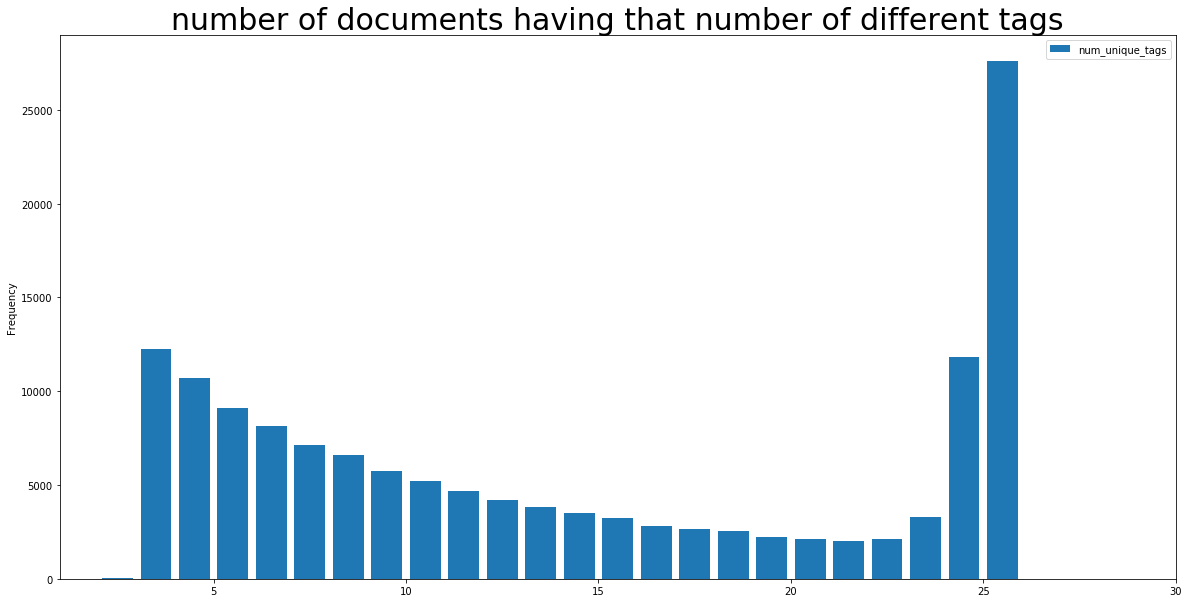

In [15]:
docs_df[['num_unique_tags']].plot(kind='hist',bins=np.arange(1.0,30,1),rwidth=0.8)

plt.gcf().set_size_inches(20,10)
plt.gca().set_title('number of documents having that number of different tags',fontsize=30)
plt.gca().set_xlim(1,30)

(1, 150)

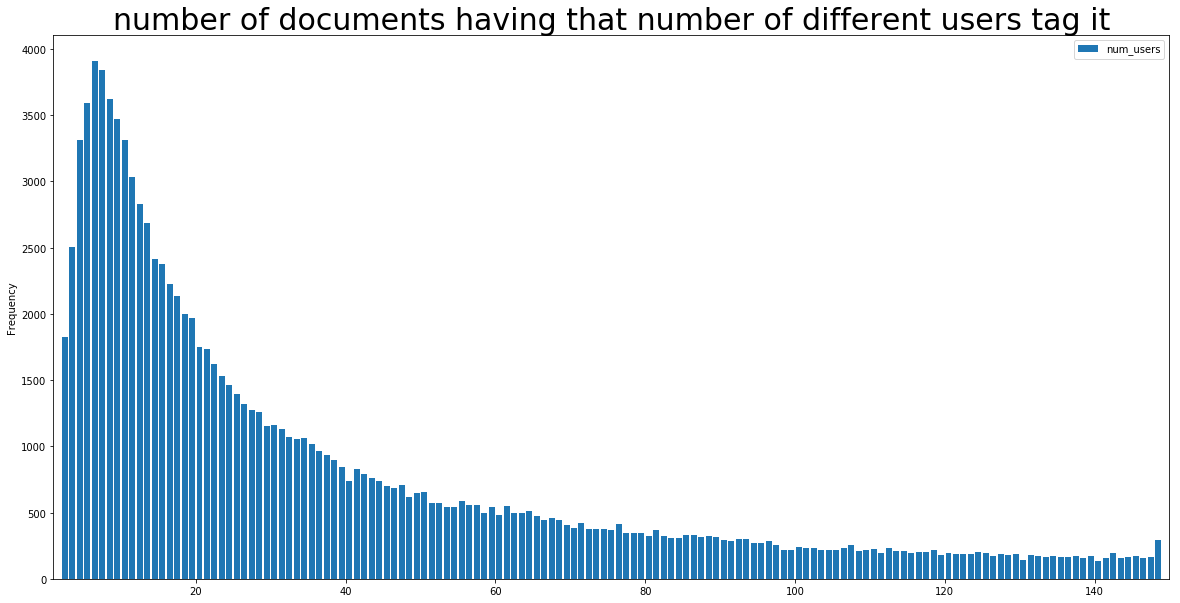

In [16]:
docs_df[['num_users']].plot(kind='hist',bins=np.arange(1.0,150,1),rwidth=0.8)
plt.gcf().set_size_inches(20,10)
plt.gca().set_title('number of documents having that number of different users tag it',fontsize=30)
plt.gca().set_xlim(1,150)

In [18]:
tagsets = [tagset.split(',') for tagset in docs_df["unique_tags"].values]

flat_list = []

for tagset in tagsets:
    for tag in tagset:
        flat_list.append(tag)
        
flat_set = set(flat_list)

## unique tags

In [19]:
len(flat_set)

63474